# Palleja & Suez GMM at baseline v.s. V1-V2 distance of GMM random forest
## Using vegdist for distance (Bray-Curtis), and it is based on GMM!

## 1. Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/Users/Jessica/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
genus = pd.read_csv('/Users/Jessica/Documents/Lab/Multiple_longitudinal/Microbe_resilience/Palleja_Suez_GMM_baseline_predict_GMM_vegdist_bray_forML.txt',
                   delimiter = "\t")

In [3]:
genus.head()

,Study,ID,Dist_V1V2,Timepoint,Run,MF0001,MF0002,MF0003,MF0004,MF0005,...,MF0124,MF0125,MF0126,MF0127,MF0128,MF0129,MF0130,MF0131,MF0132,MF0133
0,Suez,603,0.061220,Baseline,ERR2749744,121,83,103,3,26,...,156,64,48,81,0,20,19,12,77,25
1,Suez,604,0.167643,Baseline,ERR2749783,73,44,88,4,22,...,161,113,29,100,6,29,24,9,86,56
2,Suez,605,0.213152,Baseline,ERR2749816,79,45,99,2,30,...,160,88,26,92,7,6,19,3,100,60
3,Suez,606,0.359143,Baseline,ERR2749856,75,47,96,3,25,...,150,83,22,83,1,16,29,7,58,60
4,Suez,704,0.331984,Baseline,ERR2750073,77,46,101,3,23,...,154,101,30,91,2,24,25,7,85,55


### Separate the data into meta variables and microbe variables

In [4]:
microbe = genus.iloc[:, 5:len(genus.columns)]

In [5]:
microbe.head()

,MF0001,MF0002,MF0003,MF0004,MF0005,MF0006,MF0007,MF0008,MF0009,MF0010,...,MF0124,MF0125,MF0126,MF0127,MF0128,MF0129,MF0130,MF0131,MF0132,MF0133
0,121,83,103,3,26,20,86,86,15,0,...,156,64,48,81,0,20,19,12,77,25
1,73,44,88,4,22,19,112,112,5,0,...,161,113,29,100,6,29,24,9,86,56
2,79,45,99,2,30,18,107,108,3,0,...,160,88,26,92,7,6,19,3,100,60
3,75,47,96,3,25,14,106,106,12,0,...,150,83,22,83,1,16,29,7,58,60
4,77,46,101,3,23,15,103,104,7,0,...,154,101,30,91,2,24,25,7,85,55


### Variance Test: to exclude meaningless features

In [6]:
# Calculate variances
all_var = microbe.var()
all_var_val = all_var.values.tolist() #Extract only the variances to a list

Text(0.5, 0, 'All variance')

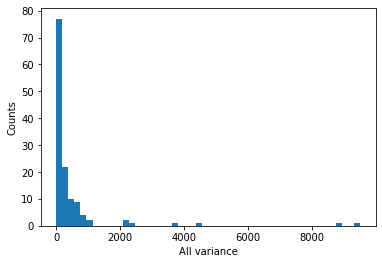

In [7]:
# Plot all variace
plt.hist(all_var_val, density=False, bins=50)  # density=False would make counts
plt.ylabel('Counts')
#plt.xlim([0, 1])
plt.xlabel('All variance')

In [8]:
# The largest variance is only 0.031, so the variance threshold =1 doesn't apply 
all_var.max() 

9516.235294117649

In [9]:
# Define filter_by_variance function
#from sklearn.feature_selection import VarianceThreshold

#def filter_by_variance(data, var_thr):
#    constant_filter = VarianceThreshold(threshold=var_thr)
#   constant_filter.fit(data)
#    features_to_keep = data.columns[constant_filter.get_support()]
#    return features_to_keep

## 2. Set up evaluation environment. Use stratified 5-fold CV to determine the accuracy of the model

In [10]:
my_data = genus.drop(columns=['Timepoint', 'Study', 'Run'])

In [11]:
my_data.head()

,ID,Dist_V1V2,MF0001,MF0002,MF0003,MF0004,MF0005,MF0006,MF0007,MF0008,...,MF0124,MF0125,MF0126,MF0127,MF0128,MF0129,MF0130,MF0131,MF0132,MF0133
0,603,0.061220,121,83,103,3,26,20,86,86,...,156,64,48,81,0,20,19,12,77,25
1,604,0.167643,73,44,88,4,22,19,112,112,...,161,113,29,100,6,29,24,9,86,56
2,605,0.213152,79,45,99,2,30,18,107,108,...,160,88,26,92,7,6,19,3,100,60
3,606,0.359143,75,47,96,3,25,14,106,106,...,150,83,22,83,1,16,29,7,58,60
4,704,0.331984,77,46,101,3,23,15,103,104,...,154,101,30,91,2,24,25,7,85,55


In [12]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)

## Step 3: Try out Random Forest (within the 5 - Fold CV setup)

In [13]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from collections import OrderedDict

In [14]:
seed = 42

In [15]:
X, y = my_data.drop(columns=['ID','Dist_V1V2']), my_data.Dist_V1V2

In [16]:
X.head()

,MF0001,MF0002,MF0003,MF0004,MF0005,MF0006,MF0007,MF0008,MF0009,MF0010,...,MF0124,MF0125,MF0126,MF0127,MF0128,MF0129,MF0130,MF0131,MF0132,MF0133
0,121,83,103,3,26,20,86,86,15,0,...,156,64,48,81,0,20,19,12,77,25
1,73,44,88,4,22,19,112,112,5,0,...,161,113,29,100,6,29,24,9,86,56
2,79,45,99,2,30,18,107,108,3,0,...,160,88,26,92,7,6,19,3,100,60
3,75,47,96,3,25,14,106,106,12,0,...,150,83,22,83,1,16,29,7,58,60
4,77,46,101,3,23,15,103,104,7,0,...,154,101,30,91,2,24,25,7,85,55


In [17]:
# All the methods to be compared
ensemble_clfs = [
    ("RF, max_features='sqrt', max_depth = 2",
       RandomForestRegressor(random_state=seed, max_depth=2,
                            oob_score=True, max_features = "sqrt")),
    ("RF, max_features='sqrt', max_depth = 5",
       RandomForestRegressor(random_state=seed, max_depth=5, 
                            oob_score=True, max_features = "sqrt")),
    ("RF, max_features='sqrt', max_depth = 10",
       RandomForestRegressor(random_state=seed, max_depth=10, 
                            oob_score=True, max_features = "sqrt")),
    ("RF, max_features='log2', max_depth = 2",
       RandomForestRegressor(random_state=seed, max_depth=2, 
                            oob_score=True, max_features = "log2")),
    ("RF, max_features='log2', max_depth = 5",
       RandomForestRegressor(random_state=seed, max_depth=5, 
                            oob_score=True, max_features = "log2")),
    ("RF, max_features='log2', max_depth = 10",
       RandomForestRegressor(random_state=seed, max_depth=10,
                            oob_score=True, max_features = "log2"))
     ]

In [18]:
# OOB error
# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 500
max_estimators = 1800

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 25):
        clf.set_params(n_estimators=i, n_jobs = 2)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

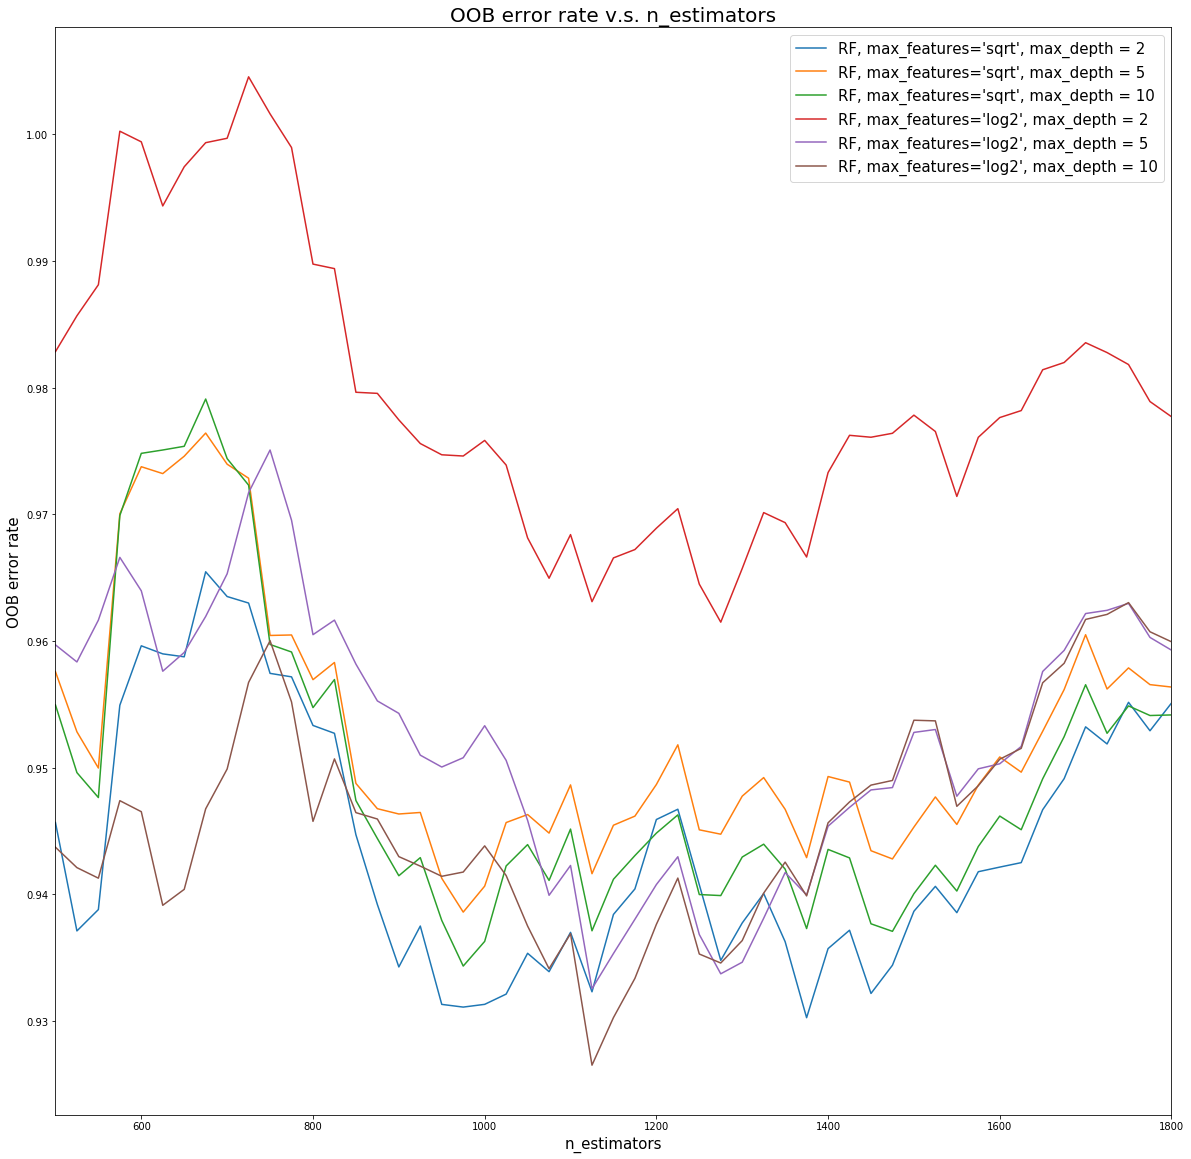

In [20]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)
plt.rcParams["figure.figsize"] = [30, 30]
plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators", fontsize = 15)
plt.ylabel("OOB error rate", fontsize = 15)
plt.legend(loc="upper right", fontsize = 15)
plt.title("OOB error rate v.s. n_estimators", fontsize = 20)
plt.show()

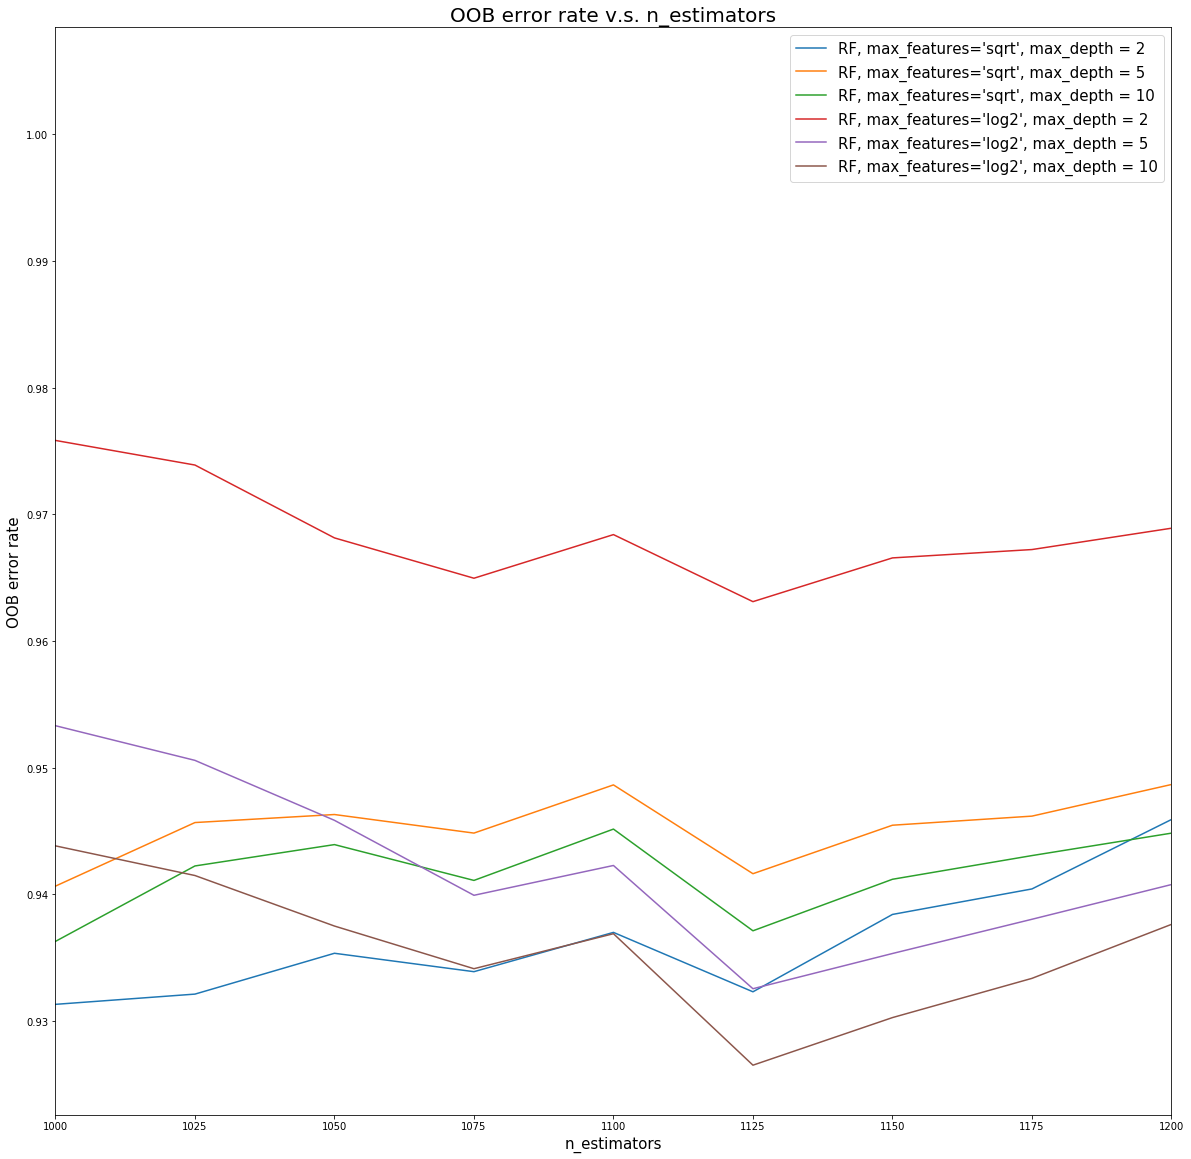

In [22]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)
plt.rcParams["figure.figsize"] = [10, 10]
plt.xlim(1000, 1200)
plt.xlabel("n_estimators", fontsize = 15)
plt.ylabel("OOB error rate", fontsize = 15)
plt.legend(loc="upper right", fontsize = 15)
plt.title("OOB error rate v.s. n_estimators", fontsize = 20)
plt.show()

**From the plot above, we can see that the blue line at 1125 estimators is the best**

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
import random
import math
seed = 42
X, y = my_data.drop(columns=['ID','Dist_V1V2']), my_data.Dist_V1V2
kf = KFold(n_splits=5)

In [24]:
# Max_depth = 2, max_features = "log2"
RF_1 = RandomForestRegressor(random_state=seed, max_depth=10, n_estimators= 1125, 
                            oob_score=True, max_features = "log2")
result_negMSE_1 = cross_val_score(RF_1, X, y, cv = kf, scoring="neg_mean_absolute_error")
print("Avg kfold neg MSE: {}".format(result_negMSE_1.mean())) #Print average accuracy
output = cross_validate(RF_1, X, y, cv=kf, scoring = 'neg_mean_absolute_error', return_estimator =True)

Avg kfold neg MSE: -0.07955850663291777


### Calculate the feature importance per fold

In [25]:
# Get feature importance per estimator
feature_result = []
for idx, estimator in enumerate(output['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_, index = X.columns, 
                                       columns=['importance']).sort_values('importance', ascending=False)
    feature_result.append((feature_importances)) # Save the result in each loop to feature_result
    #print(feature_importances)


Features sorted by their score for estimator 0:
Features sorted by their score for estimator 1:
Features sorted by their score for estimator 2:
Features sorted by their score for estimator 3:
Features sorted by their score for estimator 4:


In [26]:
type(feature_result)

list

In [27]:
feature_result_1 = pd.DataFrame(feature_result[0])
feature_result_2 = pd.DataFrame(feature_result[1])
feature_result_3 = pd.DataFrame(feature_result[2])
feature_result_4 = pd.DataFrame(feature_result[3])
feature_result_5 = pd.DataFrame(feature_result[4])
feature_result_all = pd.concat([feature_result_1, feature_result_2, feature_result_3, 
                              feature_result_4, feature_result_5])

In [28]:
feature_result_all

,importance
MF0021,0.035651
MF0099,0.034093
MF0022,0.032814
MF0042,0.029999
MF0020,0.027892
...,...
MF0124,0.001869
MF0015,0.001192
MF0105,0.000941
MF0118,0.000661


In [29]:
# Turn rownames to colum
feature_result_all.index.name = 'Feature'
feature_result_all.reset_index(inplace=True)
feature_result_all.head(10)


,Feature,importance
0,MF0021,0.035651
1,MF0099,0.034093
2,MF0022,0.032814
3,MF0042,0.029999
4,MF0020,0.027892
5,MF0048,0.026659
6,MF0030,0.021505
7,MF0017,0.020258
8,MF0089,0.019683
9,MF0033,0.019056


In [30]:
# Select only the top 10 important features for plotting
feature_result_all.sort_values(by = "importance", ascending=False, inplace=True)

# Group features and compute the median of each group 
#https://www.kite.com/python/answers/how-to-group-a-pandas-dataframe-by-a-column-and-compute-the-mean-of-each-group-in-python
grouped_feature_result_all = feature_result_all.groupby("Feature")
mean_feature = grouped_feature_result_all.median()
mean_feature = mean_feature.reset_index() #reset index to match format

# Sort by importance
mean_feature.sort_values(by = "importance", ascending=False, inplace=True)
mean_feature.head(10)

,Feature,importance
40,MF0042,0.036856
46,MF0048,0.030541
29,MF0030,0.022583
32,MF0033,0.019668
18,MF0019,0.019405
112,MF0115,0.019374
81,MF0084,0.019231
82,MF0085,0.017338
10,MF0011,0.015815
129,MF0132,0.015155


In [32]:
feature_plotting = feature_result_all.loc[feature_result_all['Feature'].isin
                                          ([mean_feature.loc[40, ][0], mean_feature.loc[46, ][0],
                                           mean_feature.loc[29, ][0], mean_feature.loc[32, ][0],
                                           mean_feature.loc[18, ][0], mean_feature.loc[112, ][0],
                                           mean_feature.loc[81, ][0], mean_feature.loc[82, ][0],
                                           mean_feature.loc[10, ][0], mean_feature.loc[129, ][0]])]
feature_plotting.head()

,Feature,importance
262,MF0042,0.052736
524,MF0042,0.039096
263,MF0048,0.038798
393,MF0042,0.036856
264,MF0084,0.035994


In [33]:
# Manually sort the plotting order
order_list = [mean_feature.loc[40, ][0], mean_feature.loc[46, ][0],
                                           mean_feature.loc[29, ][0], mean_feature.loc[32, ][0],
                                           mean_feature.loc[18, ][0], mean_feature.loc[112, ][0],
                                           mean_feature.loc[81, ][0], mean_feature.loc[82, ][0],
                                           mean_feature.loc[10, ][0], mean_feature.loc[129, ][0]]

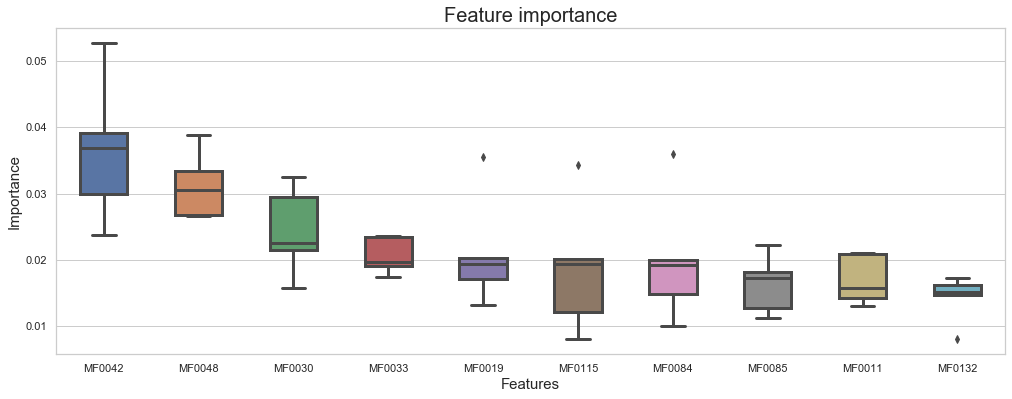

In [34]:
# Plot boxplot to see the variation of feature importance across folds 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(17,6)})
sns.set_style("whitegrid")
a = sns.boxplot(x=feature_plotting["Feature"], y=feature_plotting["importance"], 
                width=0.5, linewidth=3, order = order_list)
a.axes.set_title("Feature importance",fontsize=20)
a.set_xlabel("Features",fontsize=15)
a.set_ylabel("Importance",fontsize=15)
#a.set_xticklabels(["M00240", "M00373","M00425", "M00227", "M00342",
#              "M00715", "M00647","M00704", "M00443", "M00646"])
plt.show()
